In [1]:
# load libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import time
import os
from pysal.esda.mapclassify import Quantiles, Equal_Interval

In [2]:
# set the filepath and load in a shapefile
fp = "datasets/geo-data/gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp"

data = gpd.read_file(fp)

In [3]:
# check borough names
data.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((516401.6 160201.8, 516407.3 160210.5..."
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((535009.2 159504.7, 535005.5 159502, ..."
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((540373.6 157530.4, 540361.2 157551.9..."
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((521975.8 178100, 521967.7 178096.8, ..."
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((510253.5 182881.6, 510249.9 182886, ..."


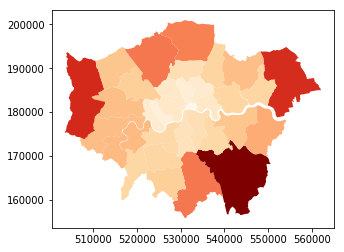

In [4]:
# testing out the data to see how it looks with a cmap
plot = data.plot(column='HECTARES', cmap='OrRd')

fig = plot.get_figure()

In [5]:
# load in new csv to merge with geodata
df = pd.read_csv("datasets/MPS_Borough_Level_Crime_Historic.csv", header=0, encoding="utf-8")

df.head()

,borough,major_category,minor_category,200801,200802,200803,200804,200805,200806,200807,...,201603,201604,201605,201606,201607,201608,201609,201610,201611,201612
0,Barking and Dagenham,Burglary,Burglary in a Dwelling,82,71,87,74,74,103,113,...,73,47,77,63,55,54,49,60,73,100
1,Barking and Dagenham,Burglary,Burglary in Other Buildings,59,68,56,53,57,39,44,...,32,42,42,47,32,33,45,40,24,19
2,Barking and Dagenham,Criminal Damage,Criminal Damage To Dwelling,79,52,55,73,63,80,73,...,50,36,58,30,48,38,31,29,32,26
3,Barking and Dagenham,Criminal Damage,Criminal Damage To Motor Vehicle,142,138,118,158,126,96,116,...,73,61,81,73,69,68,61,69,67,59
4,Barking and Dagenham,Criminal Damage,Criminal Damage To Other Building,20,19,20,23,16,12,17,...,21,13,13,18,15,16,11,12,16,8


In [6]:
# filter to include only data labeled as 'Violence Against the Person'
filtered = df['major_category'] == 'Violence Against the Person'

violence = df[filtered]

violence

# groupby to get the sum of each by borough
df3 = violence.groupby('borough').sum()

df3.head()

,200801,200802,200803,200804,200805,200806,200807,200808,200809,200810,...,201603,201604,201605,201606,201607,201608,201609,201610,201611,201612
borough,,,,,,,,,,,,,,,,,,,,,
Barking and Dagenham,449,366,415,415,425,485,485,481,394,392,...,557,475,572,546,617,522,518,447,500,465
Barnet,385,386,413,429,524,475,516,383,383,418,...,576,634,711,677,666,661,658,677,613,598
Bexley,238,301,286,279,294,299,281,265,285,290,...,405,314,369,398,424,342,390,413,411,396
Brent,443,423,504,518,599,550,588,489,518,590,...,684,785,865,839,787,780,768,817,736,777
Bromley,454,413,470,419,473,446,585,469,441,484,...,529,481,569,558,627,523,543,606,559,607


In [7]:
# then we need to melt the df so it's in tidy format. reshape the table to keep the columns borough, category, year (as variable) and value
melted = pd.melt(violence,  id_vars=['borough','major_category','minor_category'])

melted.head()

,borough,major_category,minor_category,variable,value
0,Barking and Dagenham,Violence Against the Person,Assault with Injury,200801,180
1,Barking and Dagenham,Violence Against the Person,Common Assault,200801,99
2,Barking and Dagenham,Violence Against the Person,Grievous Bodily Harm,200801,0
3,Barking and Dagenham,Violence Against the Person,Harassment,200801,129
4,Barking and Dagenham,Violence Against the Person,Murder,200801,0


In [8]:
df2 = melted.groupby('borough').sum()

df2.head()

,value
borough,
Barking and Dagenham,44195
Barnet,47586
Bexley,30686
Brent,65867
Bromley,47917


In [9]:
# then let's pivot the dataframe to add on the column 'major_category' and add up the values for each borough by year
crime = melted.pivot_table(values='value', index=['borough','major_category'], columns='variable', aggfunc=np.sum)
crime.columns = crime.columns.get_level_values(0)
crime.head()

,variable,200801,200802,200803,200804,200805,200806,200807,200808,200809,200810,...,201603,201604,201605,201606,201607,201608,201609,201610,201611,201612
borough,major_category,,,,,,,,,,,,,,,,,,,,,
Barking and Dagenham,Violence Against the Person,449,366,415,415,425,485,485,481,394,392,...,557,475,572,546,617,522,518,447,500,465
Barnet,Violence Against the Person,385,386,413,429,524,475,516,383,383,418,...,576,634,711,677,666,661,658,677,613,598
Bexley,Violence Against the Person,238,301,286,279,294,299,281,265,285,290,...,405,314,369,398,424,342,390,413,411,396
Brent,Violence Against the Person,443,423,504,518,599,550,588,489,518,590,...,684,785,865,839,787,780,768,817,736,777
Bromley,Violence Against the Person,454,413,470,419,473,446,585,469,441,484,...,529,481,569,558,627,523,543,606,559,607


In [10]:
# join the geodataframe with the cleaned up csv dataframe
merged1 = data.set_index('NAME').join(df3)

merged1 = merged1.reindex(merged1.index.rename('borough'))

merged1.max

<bound method DataFrame.max of                          GSS_CODE   HECTARES  NONLD_AREA ONS_INNER SUB_2009  \
borough                                                                       
Kingston upon Thames    E09000021   3726.117       0.000         F     None   
Croydon                 E09000008   8649.441       0.000         F     None   
Bromley                 E09000006  15013.487       0.000         F     None   
Hounslow                E09000018   5658.541      60.755         F     None   
Ealing                  E09000009   5554.428       0.000         F     None   
Havering                E09000016  11445.735     210.763         F     None   
Hillingdon              E09000017  11570.063       0.000         F     None   
Harrow                  E09000015   5046.330       0.000         F     None   
Brent                   E09000005   4323.270       0.000         F     None   
Barnet                  E09000003   8674.837       0.000         F     None   
Lambeth              

/Users/benjaomcooley/anaconda3/envs/maps/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


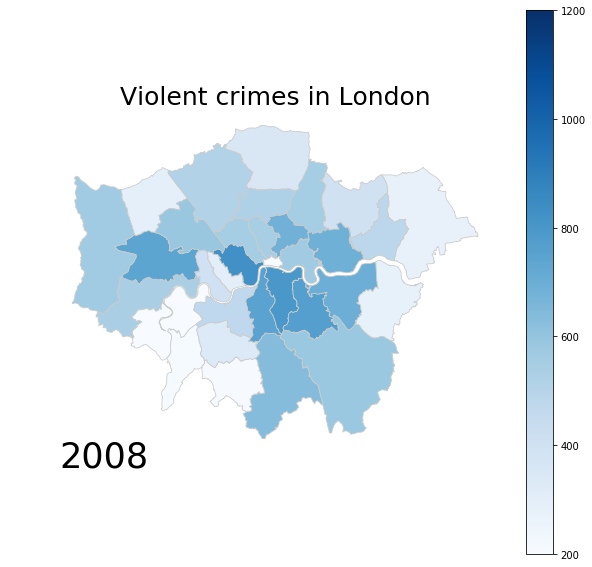

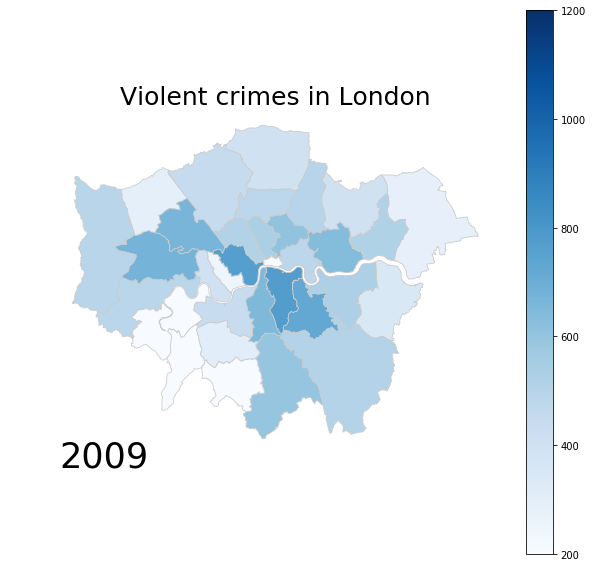

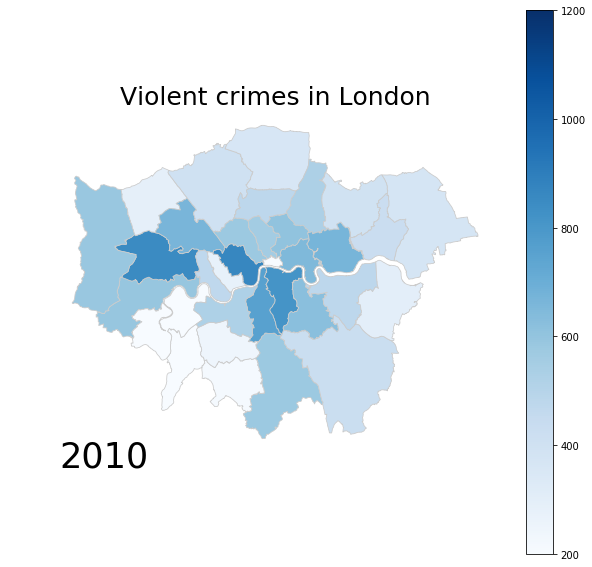

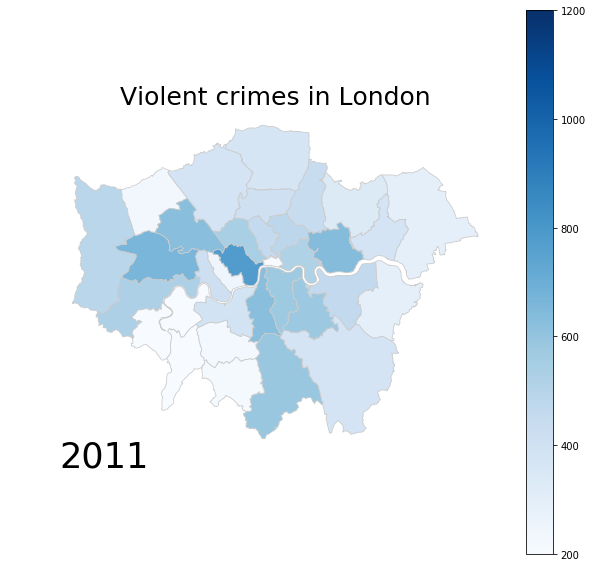

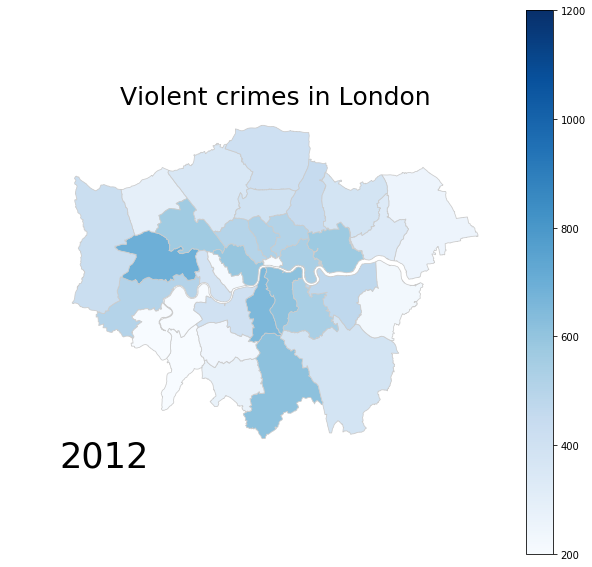

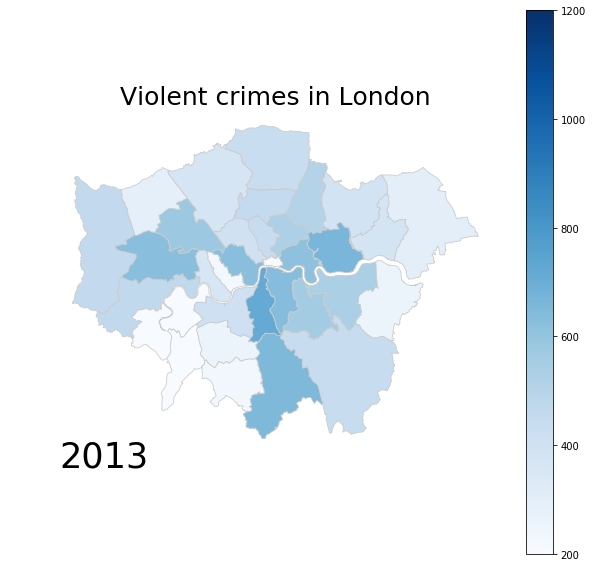

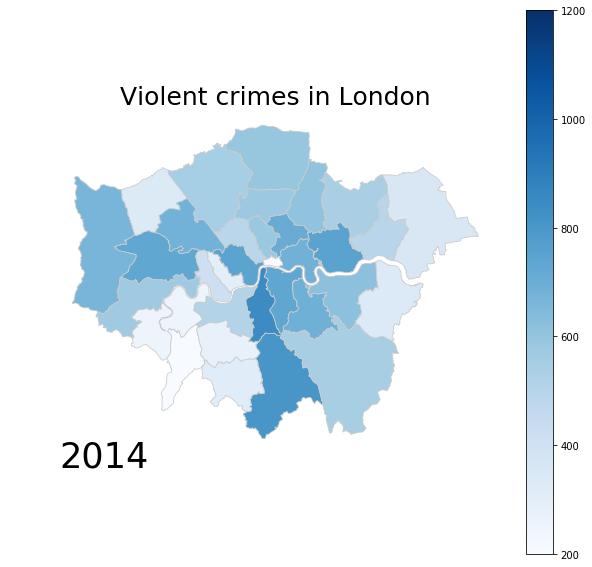

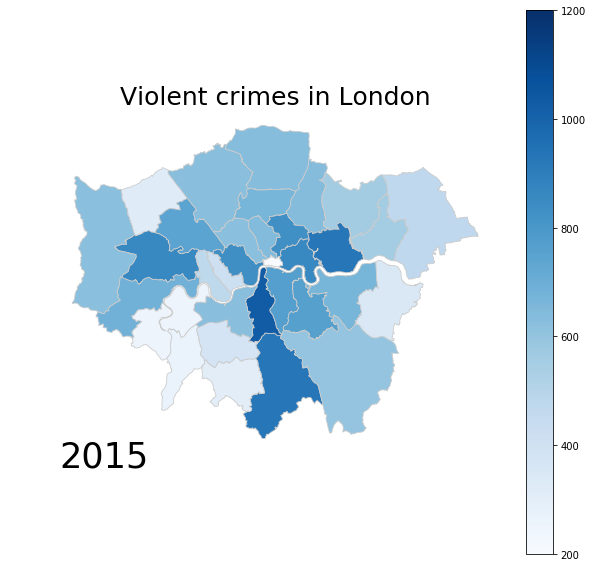

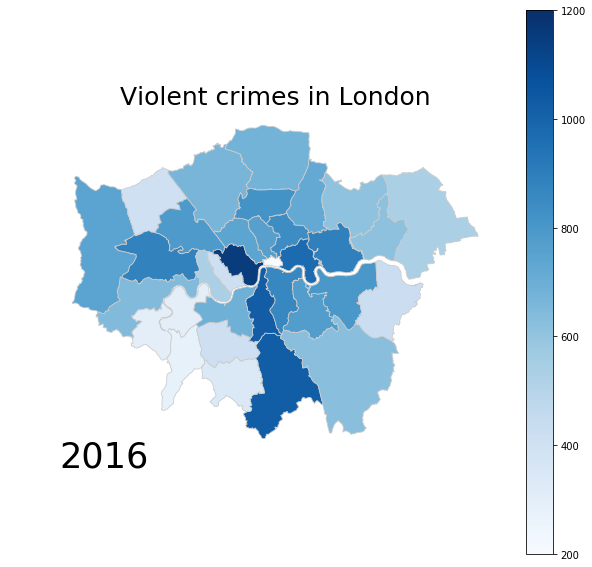

In [17]:
# CREATE A LOOP TO MAKE MULTIPLE MAPS WITH YEAR ANNOTATIONS

# save all the maps in the charts folder
output_path = 'charts/maps'

# counter for the for loop
i = 0

# list of years (which are the column names at the moment)
list_of_years = ['200807','200907','201007','201107','201207','201307','201407','201507','201607']

# set the min and max range for the choropleth map
vmin, vmax = 200, 1200

# start the for loop to create one map per year
for year in list_of_years:
    
    # create map
    fig = merged1.plot(column=year, cmap='Purples', figsize=(10,10), linewidth=0.8, edgecolor='0.8', vmin=vmin, vmax=vmax, 
                       legend=True, norm=plt.Normalize(vmin=vmin, vmax=vmax)) # UDPATE: added plt.Normalize to keep the legend range the same for all maps
    
    # remove axis of chart
    fig.axis('off')
    
    # add a title
    fig.set_title('Violent crimes in London', \
              fontdict={'fontsize': '25',
                         'fontweight' : '3'})
    
    # create an annotation for the year
    only_year = year[:4]
    
    # position the annotation to the bottom left
    fig.annotate(only_year,
            xy=(0.1, .225), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=35)
    
    # this will save the figure as a high-res png in the output path. you can also save as svg if you prefer.
    filepath = os.path.join(output_path, only_year+'_violence.png')
    chart = fig.get_figure()
    chart.savefig(filepath, dpi=300)